In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 9.7 MB/s 
     |████████████████████████████████| 596 kB 55.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.8 MB/s 
     |████████████████████████████████| 86 kB 4.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_excel('/content/Balenced_data_bengali.xlsx')
df

,Unnamed: 0,Clickbaits,sentiments
0,1331,We Can Guess Your Age With Just Three Question...,1
1,1769,This Tiny Lion Can't Roar Yet But That's Fine ...,1
2,2420,"Which Lyon Brother On ""Empire"" Is The Most Fine",1
3,2979,These Professional Fitness Instructors Tried B...,1
4,3041,10 Awesome Things You Can Make Out Of Duct Tape,1
...,...,...,...
2193,1309,A Woman Is Trying To Find The Stranger Who Hel...,3
2194,2319,checking for new messege,3
2195,2920,People Keep Making Huge Facebook Chats With Pe...,3
2196,937,Trainspotting: Then Vs Now,3


In [ ]:
import numpy as np

seq_len = 512
num_samples = len(df)

Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

Xids.shape

(2231, 512)

##Bengali model

In [ ]:
from transformers import BertTokenizer
# from transformers import AutoTokenizer, AutoModel

tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

for i, phrase in enumerate(df['Clickbaits']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

Downloading:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [ ]:
Xids

array([[  101.,   100.,  3128., ...,     0.,     0.,     0.],
       [  101.,   100.,  2168., ...,     0.,     0.,     0.],
       [  101.,   100.,  4735., ...,     0.,     0.,     0.],
       ...,
       [  101.,  2536., 25406., ...,     0.,     0.,     0.],
       [  101.,  2536., 33668., ...,     0.,     0.,     0.],
       [  101.,  2536., 23383., ...,     0.,     0.,     0.]])

In [ ]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
arr = df['sentiments'].values
arr = arr - 1
arr
# df['Sentiment'].unique()

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(2231, 3)

In [ ]:
labels[np.arange(num_samples), arr] = 1
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [ ]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [ ]:
batch_size = 32

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(32, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(32, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(32, 3), dtype=tf.float64, name=None))>

In [ ]:
split = 0.7

# we need to calculate how many batches must be taken to create 80% training set
size = int((Xids.shape[0] / batch_size) * split)

size

48

In [ ]:
train_ds = dataset.take(size)
val_ds = dataset.skip(0)

# free up memory
del dataset

In [ ]:

from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('sagorsarker/bangla-bert-base')

# we can view the model using the summary method
bert.summary()

Downloading:   0%|          | 0.00/930M [00:00<?, ?B/s]

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  164396544 
                                                                 
Total params: 164,396,544
Trainable params: 164,396,544
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

x = tf.keras.layers.Dropout(0.3)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

In [ ]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  164396544   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [ ]:
save_callback = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/bst_bengali_model_fogg',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
# model.load_weights('/content/drive/MyDrive/bst_wt_fogg')

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[save_callback]
)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.0897 - accuracy: 0.3861

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 194s 4s/step - loss: 1.0897 - accuracy: 0.3861 - val_loss: 1.0776 - val_accuracy: 0.4484
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 1.0744 - accuracy: 0.4440

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 1.0744 - accuracy: 0.4440 - val_loss: 1.0602 - val_accuracy: 0.5059
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 1.0570 - accuracy: 0.4844

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 1.0570 - accuracy: 0.4844 - val_loss: 1.0374 - val_accuracy: 0.5385
Epoch 4/20
48/48 [==============================] - ETA: 0s - loss: 1.0352 - accuracy: 0.5065

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 1.0352 - accuracy: 0.5065 - val_loss: 1.0115 - val_accuracy: 0.5865
Epoch 5/20
48/48 [==============================] - ETA: 0s - loss: 1.0105 - accuracy: 0.5573

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 187s 4s/step - loss: 1.0105 - accuracy: 0.5573 - val_loss: 0.9807 - val_accuracy: 0.6005
Epoch 6/20
48/48 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.5690

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 187s 4s/step - loss: 0.9789 - accuracy: 0.5690 - val_loss: 0.9456 - val_accuracy: 0.6309
Epoch 7/20
48/48 [==============================] - ETA: 0s - loss: 0.9540 - accuracy: 0.5853

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 0.9540 - accuracy: 0.5853 - val_loss: 0.9170 - val_accuracy: 0.6445
Epoch 8/20
48/48 [==============================] - ETA: 0s - loss: 0.9152 - accuracy: 0.6270

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 0.9152 - accuracy: 0.6270 - val_loss: 0.8677 - val_accuracy: 0.6698
Epoch 9/20
48/48 [==============================] - ETA: 0s - loss: 0.8932 - accuracy: 0.6296

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 0.8932 - accuracy: 0.6296 - val_loss: 0.8317 - val_accuracy: 0.6825
Epoch 10/20
48/48 [==============================] - ETA: 0s - loss: 0.8503 - accuracy: 0.6673

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 0.8503 - accuracy: 0.6673 - val_loss: 0.7977 - val_accuracy: 0.6929
Epoch 11/20
48/48 [==============================] - ETA: 0s - loss: 0.8419 - accuracy: 0.6543

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 0.8419 - accuracy: 0.6543 - val_loss: 0.7650 - val_accuracy: 0.7111
Epoch 12/20
48/48 [==============================] - ETA: 0s - loss: 0.8060 - accuracy: 0.6816

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 187s 4s/step - loss: 0.8060 - accuracy: 0.6816 - val_loss: 0.7322 - val_accuracy: 0.7233
Epoch 13/20
48/48 [==============================] - ETA: 0s - loss: 0.7876 - accuracy: 0.6862

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 187s 4s/step - loss: 0.7876 - accuracy: 0.6862 - val_loss: 0.7106 - val_accuracy: 0.7455
Epoch 14/20
48/48 [==============================] - 160s 3s/step - loss: 0.7647 - accuracy: 0.6934 - val_loss: 0.6937 - val_accuracy: 0.7455
Epoch 15/20
48/48 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.7135

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 0.7354 - accuracy: 0.7135 - val_loss: 0.6534 - val_accuracy: 0.7690
Epoch 16/20
48/48 [==============================] - ETA: 0s - loss: 0.7166 - accuracy: 0.7129

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 187s 4s/step - loss: 0.7166 - accuracy: 0.7129 - val_loss: 0.6327 - val_accuracy: 0.7731
Epoch 17/20
48/48 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.7240

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 187s 4s/step - loss: 0.7038 - accuracy: 0.7240 - val_loss: 0.6093 - val_accuracy: 0.7799
Epoch 18/20
48/48 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7324

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 241s 5s/step - loss: 0.6868 - accuracy: 0.7324 - val_loss: 0.5915 - val_accuracy: 0.7844
Epoch 19/20
48/48 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.7454

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 187s 4s/step - loss: 0.6522 - accuracy: 0.7454 - val_loss: 0.5732 - val_accuracy: 0.7912
Epoch 20/20
48/48 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.7448

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/bst_bengali_model_fogg/assets


48/48 [==============================] - 188s 4s/step - loss: 0.6646 - accuracy: 0.7448 - val_loss: 0.5587 - val_accuracy: 0.8007


##Polynomial Decay

## Scheduler

In [ ]:
# def scheduler(epoch, lr):
#     if epoch < 1:
#         return lr
#     else:
#         # return lr * tf.math.exp(-0.000001)
#         return lr/2

In [ ]:
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

##Exponential

In [ ]:
# initial_learning_rate = 0.1
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

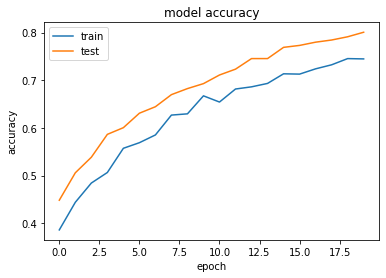

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

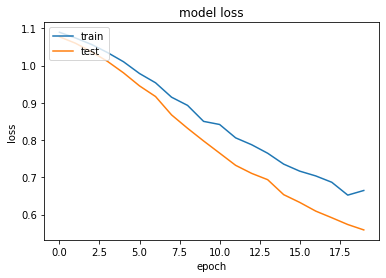

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('/content//drive/MyDrive/best_bengali_fogg')

INFO:tensorflow:Assets written to: /content//drive/MyDrive/best_bengali_fogg/assets


INFO:tensorflow:Assets written to: /content//drive/MyDrive/best_bengali_fogg/assets


In [ ]:
!zip -r /content/best_model.zip /content/best_model

  adding: content/best_model/ (stored 0%)
  adding: content/best_model/saved_model.pb (deflated 92%)
  adding: content/best_model/assets/ (stored 0%)
  adding: content/best_model/variables/ (stored 0%)
  adding: content/best_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/best_model/variables/variables.index (deflated 76%)
  adding: content/best_model/keras_metadata.pb (deflated 95%)


In [ ]:
from google.colab import files
files.download('/content/best_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load and Predict

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/bst_wt_fogg')

# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# predicted = model.predict(df['Tweet'])

In [ ]:
an = np.array([np.argmax(i) for i in predicted])
an
# arr

In [ ]:
score = model.evaluate(train_ds) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

3/3 [==============================] - 9s 1s/step - loss: 0.5062 - accuracy: 0.8125
Test loss: 0.5062158107757568
Test accuracy: 0.8125


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
an = []

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Clickbaits'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    an.append(pred)

# df.head()

In [ ]:
an = np.array(an)
an

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
print(classification_report(arr, an))

              precision    recall  f1-score   support

           0       0.51      0.09      0.15       899
           1       0.27      0.00      0.01       667
           2       0.29      0.91      0.44       665

    accuracy                           0.31      2231
   macro avg       0.36      0.33      0.20      2231
weighted avg       0.37      0.31      0.20      2231



In [ ]:
conf = confusion_matrix(arr, an)

In [ ]:
conf

array([[823,  55,  22],
       [138, 497,  31],
       [159,  73, 400]])

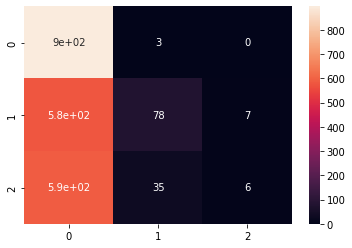

In [ ]:
import seaborn as sns
sns.heatmap(conf, annot=True)

In [ ]:
 from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, arr, an, cv=5, scoring='f1_macro')
scores

In [ ]:
stmt = input()
probs = model.predict(prep_data(stmt))[0]

probs

@TheRafaMafia Hey there! You can view the video here:  https://t.co/f2K2rqGf79 where you are briefly featured at 1:02. Enjoy!


array([0.92497486, 0.01838735, 0.01129976, 0.00166099, 0.02466378,
       0.00705248, 0.0119608 ], dtype=float32)

In [ ]:
import numpy as np

np.argmax(probs)

0

In [ ]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('test.tsv', sep='\t')
df.head()

In [ ]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

In [ ]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

In [ ]:
df.tail()